# Planning

1. Make a general template for geant4, which should be just including the most basic elements, so it can carry out more flexible setting

2. Setting up following setting in different repo
- Na22 source
- A single CsI crystal with SiPM attached to it. This setting is for simulating scintillator detector more realisticly
- A Xenon gas with shielding plate, this setting is for simulating more realistic positornium generator
- Quantum dot dark box setting (optional)

3. For physics list
- Verify from tom's positronium generation mechanism (how to import custom physics list)

4. For the generated data file, also sensitive detector setting
- It should include: 
  - Scintillator detector, which count the number of optical photon corresponding to the event.
  - Ideal detector, measuring the initial and final energy that a particular particle deposit inside the detector.

5. For the particle generation, which should include
- Na22 source
- Cosmic ray
- Other customized stuff

# Expectation
I expect upcoming simulation could achieve the following goals
1. Provide an Ideal information of the setup
  - The particle that hits the detector
  - Track information (Can be provide by hit)
  - Parent information (Can be provided by hit)
  - Time information (Can be provided by hit)
  - Position information (Can be provided by hit)
  - Energy information (Can be provided by hit)
  - Detector name that it hit (Can be provided by hit)
  - Scintillation count (Need toreport in a format track:# optical photon at the end of an Event)
  - Energy deposition details (which likely not possible as heavily many resource will be taken)
2. Provide a more realistic information of the setup
  - Track ID (For mapping to ideal case)
  - Parent ID (For mapping to ideal case)
  - Energy deposition
  - Timing information
  - Detector name
  - Scintillation count (For scintillator counters)
  - Digitized electronic signal (Simulating our setup precisely)

Particle definition:
1. First generation particles (Which is everything generated by the Na22)
2. Second generation particles (which is everything induced by the first generation particles)
3. Third generation particles (optical photon)


Few type of detector
- Simply monitor (No other purpose but monitor the particles, an Ideal case, e.g. Toms monitoring of Na22 first generation particle at disk)
- Tracker (Our Xenon gas for example) [Physically we do see the position, and time, Energy deposition, and trackID]
- Calorimeter (Our CsI crystal surrounding it) [We should see the time, energy deposition, detector ID]



For the Ideal case, to make it precise to getting such precise details,
- Tracker
1. Initial data, including the first and second generation particle crossing (presteppoing) the geometrical boundary or creation inside the detector will be included.
2. Last data, including the first and second generation particle crossing(poststeppoing) the geometrical boundary or killed inside the detector will be included.

- Calorimeter
1. Initial data, including the first particle crossing (presteppoing) the geometrical boundary or creation inside the detector will be included.
2. Last data, including the first particle crossing(poststeppoing) the geometrical boundary or killed inside the detector will be included.

Scintillation counting (How it could be done)
1. If a first generation particles generate a secondary particle in a scintillator, the secondary particle has the parent ID of the the first generation particles, the third generation particles having the parent ID of the second generation etc
So in principle, we could have a map of track, which map the track ID into the number of optical photon count, then we make a listed map, which map all the tracks into their corresponding parent ID recursively, we will have a mapping from trackID(all generation) to trackID(first generation), then for each first generation particles, sum over all its secondary trackID optical photon count we will have the correspondance.




Few type of detector
- Tracker (Our Xenon gas for example) 
- Calorimeter (Our CsI crystal surrounding it)


# Geant4 study plan
- Defining Hit class, Hit collection
Potential resource
  - https://agenda.infn.it/event/7698/contributions/69590/attachments/50573/59738/Pandola_-_Kernel.pdf
  - https://indico.cern.ch/event/294651/sessions/55918/attachments/552022/760640/UserActions.pdf
  - https://indico.cern.ch/event/782305/contributions/3256028/attachments/1793321/2922650/2b_UserActions.pdf
  - https://www.youtube.com/watch?v=SVoddk8S-mk
  - Novice Example N02 (Learn HIT collection to store datas)
  - B4c
  - https://jeffersonlab.github.io/geant4-tutorials/HandsOn3/index.html
  - https://geant4-userdoc.web.cern.ch/UsersGuides/ForApplicationDeveloper/html/Detector/hit.html#hit
  - https://www.fe.infn.it/u/paterno/Geant4_tutorial/slides_further/Scoring%20and%20analysis/Scoring_Aso.pdf
- Defining Digit, Digitization
Potential resource
  - Gamma Ray Space Telescope (advanced example)
  - https://indico.cern.ch/event/75452/contributions/2089769/attachments/1049576/1496253/HitsAndDigits.pdf
- Understanding multithreading
Potential resource
  - https://indico.fnal.gov/event/57914/contributions/260765/attachments/164432/218103/g4-mt-tasking-syjun.pdf

- Understanding Scintillator detector
Potential resource
  - Novice Example N06 (Scintillation materials and scintillation spectra specification)
  - extended/OpNovice
  - Underground physics (advanced example)
  - CaTS (advanced example, using G4Opticks to do optical physics with GPU)
  - https://indico.cern.ch/event/1052654/contributions/4525304/attachments/2310901/3932510/G4RandD_v4.pdf
- Extended new physics
Potential resource
  - Novice Example N04 (For fun, Pythia primary event generator)
  - exoticphysics (extended example)

## Hit class study



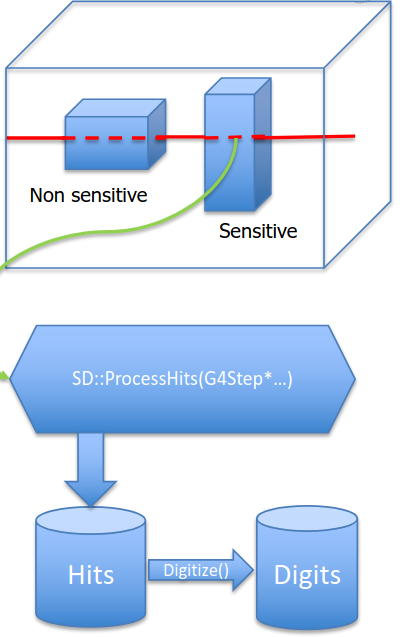


To define a sensitive volume, we need to assign the logic volumes by a **ConstructSDandField()** .
The usual workflow
1. Define detectors and ConstructSDandField
2. attribute the logic volume by the SD
To create a sensitive detector (SD) object by
```cpp
G4VSensitiveDetector* mySD= new MySD("MySD","MyHitsCollection"); //You define the class MySD, which derived from G4VSensitiveDetector class
SetSensitiveDetector("MyLogicVolumeName",mySD); 
```


To define the MySD, you need to define the following functions
```cpp 
// detector.hh
#include "G4SensitiveDetector.hh"
class MySD:public G4VSensitiveDetector{
    public:
        MySD(const G4String& name, const G4String& hitsCollectionName); //Actually without the parameter hitsCollectionName things still work out
        virtual ~MySD();
        virtual void Initialize(G4HCofThisEvent* hce); //Start by every stuff, here hce will be assigned to a Hit collections
        virtual G4bool ProcessHits(G4Step* aStep, G4TouchableHistory* ROhist); //triggered by every step
        virtual void EndOfEvents(G4HCofThisEvent* hce);
};
```

You may also want to define a hit class

```cpp
// Example for storing energy deposition of each step
class MyHit
{
    public:
        MyHit();
        void SetEdep(G4double edep);
        G4double GetEdep() const;
    private:
        G4double fEdep; 
}

```

To call the Hit from the event, 

```cpp
G4bool MySD::ProcessHits(G4Step* step, G4TouchableHistory* /*history*/)
{
MyHit* newHit = new MyHit();
// Get some properties from G4Step and set them to the hit
// newHit->SetXYZ();
G4double edep = step->GetTotalEnergyDeposit();
newHit->SetEdep(edep);
// ...
return true;
}

```

Since the Hit class will only assign once in a hit, you would likely want to have it store into a hit collection, 
options
1. G4THitsCollections
2. std::vector<MyHiT>
3. Other stuff that can store list data

For approach 1
```cpp
#include "G4VHit.hh" // To define hit collections
class MyHit : public G4VHit
{
// the class definition as before
// utility functions (called by Geant4)
virtual void Draw();
virtual void Print();
};
typedef G4THitsCollection<MyHit> MyHitsCollection;
```
```cpp
// Define hit collections
void MySD::MySD(const G4String& name, const G4String& hitsCollectionName):G4VSensitiveDetector(name), fHitsCollection(0)
{
collectionName.insert(hitsCollectionName); // You include and register the collection name to Geant4
}
void MySD::Initialize(G4HCofThisEvent* hce)
{
    fHitsCollection = new MyHitsCollection (SensitiveDetectorName, collectionName[0]); //You initialize need to create the hcID and hit collection from the start of each event.
    G4int hcID = G4SDManager::GetSDMpointer()>GetCollectionID(collectionName[0]);
    hce->AddHitsCollection(hcID, hitsCollection);
}
```